# Predicting Seizures: current Kaggle project

## 09/17/2017

Kaggle, a popular machine learning website, has recently began a competition requesting the prediction of seizures given timeseries data for epilepsy patients. More can be read about the particular project at [this website](https://www.kaggle.com/c/melbourne-university-seizure-prediction) where a description of the data is also provided.

I believe this project provides a great platform to test out the hadoop/theano framework at Vanderbilt given the immense date set provided on these medical patients. Training data is supplied for three patients where observational data per patient exceeds 5.5 Gb for the training sets and 6+ Gb for testing data.

The main scientific problems I currently address are based on the intersection of astrophysics and artificial intelligence / machine learning. For example, the [Gaia Experiment](http://sci.esa.int/gaia/) recently released astrophysical data on over 1 billion stars. One current idea is the calculation of a two-point correlation function of stellar positions, an operation that is $O(n^2)$ in complexity. Another possible application is in the detection of extra solar planets (planets orbitting nearby stars that are not the sun).

Below, I outline a hypothesis in approaching the Kaggle problem, outlining the need for robust computational resources and in the process.

The main approaches I plan on outlining in this notebook are the 

1.  Density of states methods, and

2. Granger Causality. 


## Density of states
__*Current issues*__: treating zeros as Nans.


The density of states idea relies on one hypothesis, that being that the electrode measurements sample enough of the possible states of the system $g(s)$, such that the partition function can be written as:


$$
Z(t) = \int_s ds ~ g(s, t) \approx \sum_k f_k(t),
$$

where the index $k$ counts over what samples we have of the system at time $t$. In this case, any physical observable $O(t)$, can be approximately sampled over the ensemble as follows:

$$
O(t) \approx \frac{\sum_k O_k(t) f_k(t)}{\sum_k f_k(t)}.
$$

The trick here is to find an appropriate observable $O(t)$ such that it captures a precursor to the seizure state. My hypothesis is to test an appropriate measure to capture the statistical state of a two-state system. As a first step, I would like to test the following definition:

$$
O(t) \equiv I(t)^{(p)} = \frac{f(t)^{(p)}_S - f(t)^{(p)}_N}{f(t)^{(p)}_S + f(t)^{(p)}_N}
$$

where $f(t)^{(p)}_S$ is an "averaged" seizure state voltage trained over the seizured state data set for a given electrode $p$, and $f(t)^{(p)}_N$ is similiary defined. A first stab at defining these functions may be:

$$
f(t)^{(p)} = \frac{1}{M} \sum_m f(t)^{(p)}_m
$$

where m is an index that sums over all of the known state wave forms at a given time for each state, per electrode. It is not clear whether or not one should treat each electrode separately, hence I will treat each separately for now and continue to build these two functions from our available data below.

## Constructing the learned functions: $~~f(t)^{~(p)}_S$ and $~~f(t)^{~(p)}_N$ 


The function that constructs our training functions is as follows:

In [158]:
def construct_learned_functions(sample_rate, verbose = False):
    
    file_dir = '/Users/richard/data/seizure_data/train_1/'

    col_names = ["electrode_%s" % x for x in range(1,17)]

    test_filename = file_dir + '1_1_0.mat'
    total_measurements = mat_pandas(test_filename, col_names, 1)[0].shape[0]

    list_seizure     = gb.glob(file_dir + '1_*_1.mat')
    list_non_seizure = gb.glob(file_dir + '1_*_0.mat')

    down_sample_rate = sample_rate
    N_samples        = int(total_measurements / down_sample_rate) 
    N_electrodes     = 16

    f_seizures    = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    f_nonseizures = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    N_seizures    = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    N_nonseizures = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    
    sf_seizures    = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    sf_nonseizures = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    sN_seizures    = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    sN_nonseizures = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    
    for k, filename in enumerate(list_non_seizure):
        sf_nonseizures, sN_nonseizures  = mat_pandas(filename, col_names, down_sample_rate, N_samples, N_electrodes)
        
        f_nonseizures += sf_nonseizures
        N_nonseizures += sN_nonseizures
        
        print(filename)
        
    for k, filename in enumerate(list_seizure):
        
        sf_seizures, sN_seizures = mat_pandas(filename, col_names, down_sample_rate, N_samples, N_electrodes)
        
        f_seizures += sf_seizures
        N_seizures += sN_seizures
        
        print(filename)
         
    return (f_nonseizures / N_nonseizures), (f_seizures / N_seizures)


In [ ]:
f_N, N_nonseizures, f_S, N_seizures = construct_learned_functions(1, True)

/Users/richard/data/seizure_data/train_1/1_1000_0.mat
/Users/richard/data/seizure_data/train_1/1_1001_0.mat
/Users/richard/data/seizure_data/train_1/1_1002_0.mat
/Users/richard/data/seizure_data/train_1/1_1003_0.mat
/Users/richard/data/seizure_data/train_1/1_1004_0.mat
/Users/richard/data/seizure_data/train_1/1_1005_0.mat
/Users/richard/data/seizure_data/train_1/1_1006_0.mat
/Users/richard/data/seizure_data/train_1/1_1007_0.mat
/Users/richard/data/seizure_data/train_1/1_1008_0.mat
/Users/richard/data/seizure_data/train_1/1_1009_0.mat
/Users/richard/data/seizure_data/train_1/1_100_0.mat
/Users/richard/data/seizure_data/train_1/1_1010_0.mat
/Users/richard/data/seizure_data/train_1/1_1011_0.mat
/Users/richard/data/seizure_data/train_1/1_1012_0.mat
/Users/richard/data/seizure_data/train_1/1_1013_0.mat
/Users/richard/data/seizure_data/train_1/1_1014_0.mat
/Users/richard/data/seizure_data/train_1/1_1015_0.mat
/Users/richard/data/seizure_data/train_1/1_1016_0.mat
/Users/richard/data/seizure_d

After averaging over all of the training sets, though unequal in number, we can take a look at the processed waveform:

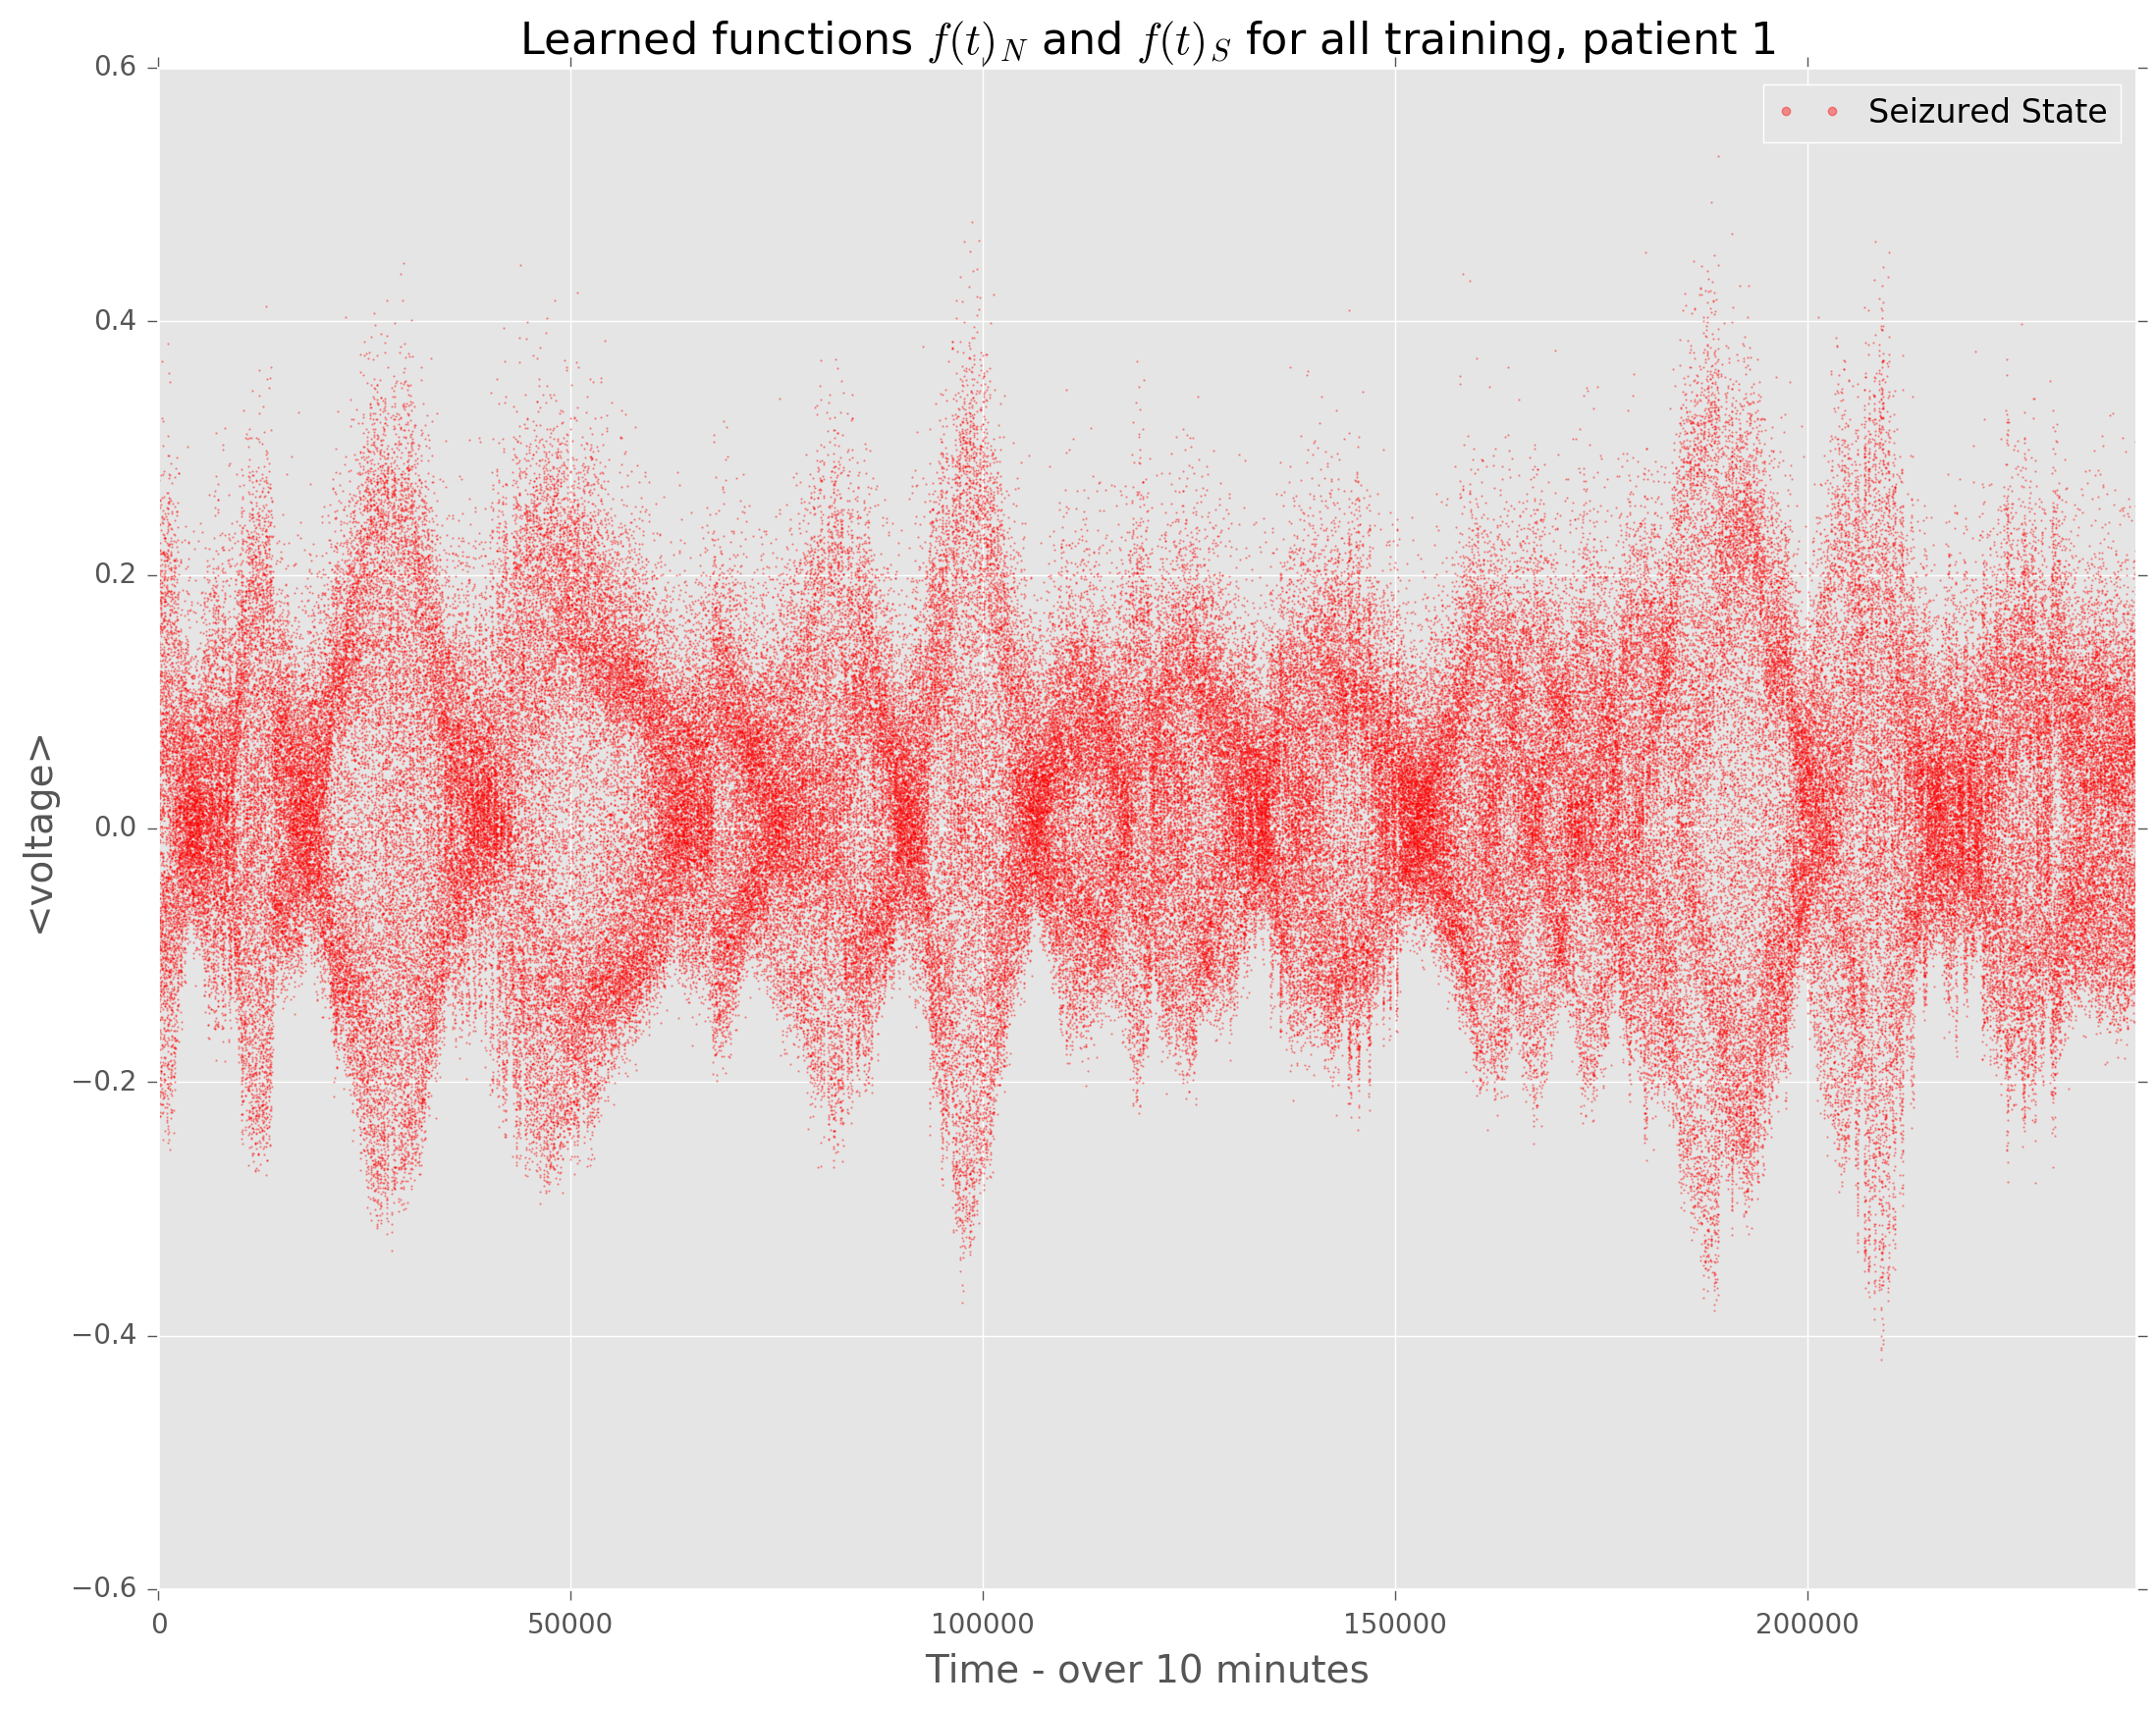

In [153]:
fig = plt.figure(figsize=(13,10));
#(f_N/N_nonseizures).mean(axis=1).plot(style='.', markersize=0.6, color = 'k', alpha = 0.4, label='Normal State');
(f_S/N_seizures).mean(axis=1).plot(style='.', markersize=0.6, color = 'r',   alpha = 0.4, label='Seizured State');
plt.legend(loc='best', markerscale=10);
plt.grid(True);
plt.title(r'Learned functions $f(t)_N$ and $f(t)_S$ for all training, patient 1', fontsize=16);
plt.xlabel('Time - over 10 minutes', fontsize=14);
plt.ylabel('<voltage>', fontsize=14);
#plt.savefig('/Users/richard/Desktop/waveform.pdf');

And also all of the electrodes independently:

AttributeError: 'float' object has no attribute 'columns'

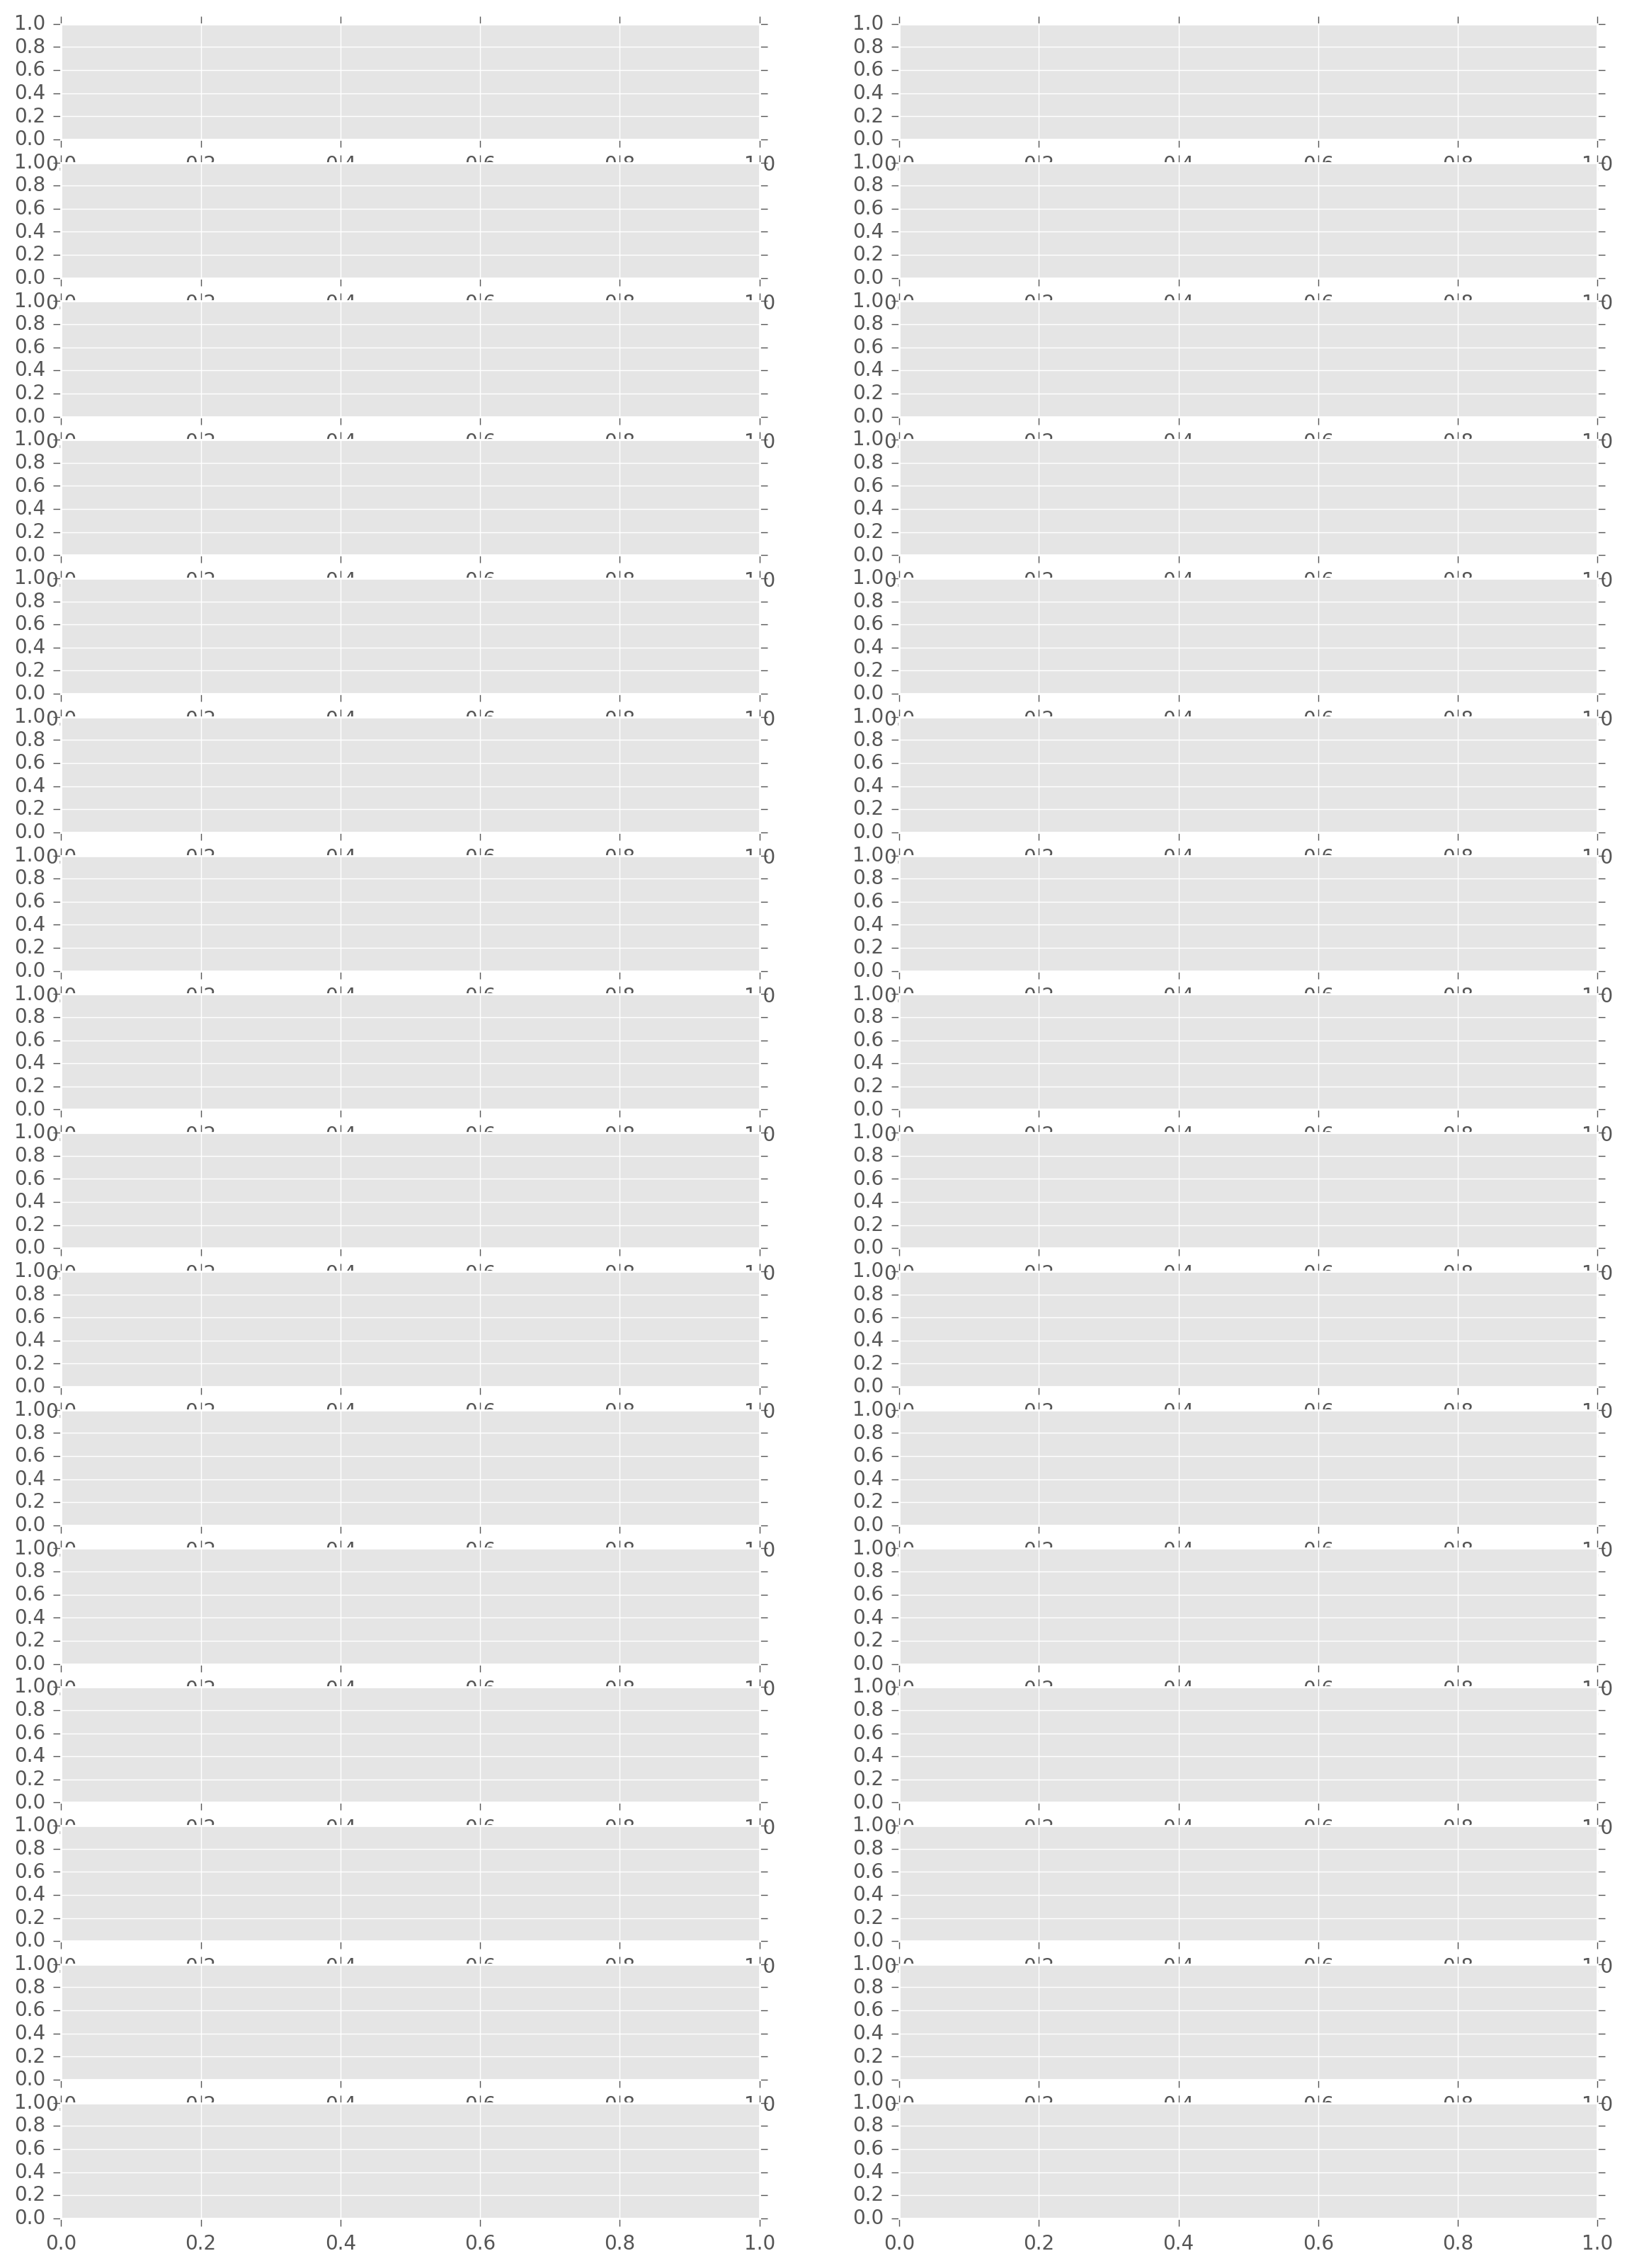

In [53]:
fig, axes = plt.subplots(16,2, figsize=(14, 20));

for k, col in enumerate(f_S.columns):
    f_S[col].plot(ax=axes[k, 0], style='.', markersize=0.6, color = 'k', alpha = 0.4, label='Normal State');
    f_N[col].plot(ax=axes[k, 1], style='.', markersize=0.6, color = 'r', alpha = 0.4, label='Seizured State');
    
plt.legend(loc='best', markerscale=10);
#plt.tight_layout(True);  

In [147]:
#helper function to load matlab files and return pandas dataframes
def mat_pandas(file_name, col_names, down_sample, N_samples=0, N_electrodes=0):

    try:
        data = sio.loadmat(file_name)
        
    except ValueError:
        print('ran into value error, returning zeros')
        return (pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names), 
                pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names))
    
    mdata = data['dataStruct']
    mtype = mdata.dtype
    ndata = {n: mdata[n][0,0] for n in mtype.names}
    data_raw = ndata['data']
    data_raw = data_raw[::down_sample, :]
    df = pd.DataFrame(data_raw,columns=col_names)
    
    del data
    return df, (~df.isin([0.0])).astype(int)

In [148]:
import pandas as pd
import numpy as np
import scipy.io as sio
import glob as gb

import matplotlib.pyplot as plt
plt.style.use('ggplot')

#py.offline.init_notebook_mode()
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')